In [1]:
import numpy as np
import pandas as pd
import pickle

# Load the datasets
ingr_map = pd.read_pickle("ingr_map.pkl")
raw_recipes = pd.read_csv("RAW_recipes.csv")
raw_interactions = pd.read_csv("RAW_interactions.csv")
pp_users = pd.read_csv("PP_users.csv")
pp_recipes = pd.read_csv("PP_recipes.csv")
interactions_validation = pd.read_csv("interactions_validation.csv")
interactions_train = pd.read_csv("interactions_train.csv")
interactions_test = pd.read_csv("interactions_test.csv")


# Show some basic information about each dataset
datasets = {
    'ingr_map': ingr_map,
    'raw_recipes': raw_recipes,
    'raw_interactions': raw_interactions,
    'pp_users': pp_users,
    'pp_recipes': pp_recipes,
    'interactions_validation': interactions_validation,
    'interactions_train': interactions_train,
    'interactions_test': interactions_test
}

info_dict = {}

for name, dataset in datasets.items():
    info_dict[name] = {
        'Number of Rows': dataset.shape[0],
        'Number of Columns': dataset.shape[1],
        'Columns': ', '.join(dataset.columns)
    }

info_df = pd.DataFrame(info_dict).T
info_df


,Number of Rows,Number of Columns,Columns
ingr_map,11659,7,"raw_ingr, raw_words, processed, len_proc, repl..."
raw_recipes,231637,12,"name, id, minutes, contributor_id, submitted, ..."
raw_interactions,1132367,5,"user_id, recipe_id, date, rating, review"
pp_users,25076,6,"u, techniques, items, n_items, ratings, n_ratings"
pp_recipes,178265,8,"id, i, name_tokens, ingredient_tokens, steps_t..."
interactions_validation,7023,6,"user_id, recipe_id, date, rating, u, i"
interactions_train,698901,6,"user_id, recipe_id, date, rating, u, i"
interactions_test,12455,6,"user_id, recipe_id, date, rating, u, i"


In [2]:
raw_recipes_df = pd.read_csv('RAW_recipes.csv')
raw_interactions_df = pd.read_csv("RAW_interactions.csv")

In [3]:
from surprise import Dataset, Reader
from surprise import SVD
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
from surprise import accuracy

In [4]:
data = raw_interactions_df[['user_id', 'recipe_id', 'rating']]

In [5]:
# Setup the SVD model with the best parameters
optimized_SVD = SVD(n_factors=50, n_epochs=20, lr_all=0.005, reg_all=0.1)

reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(raw_interactions_df[['user_id', 'recipe_id', 'rating']], reader)

# Split dataset into train and test sets
trainset, testset = train_test_split(data, test_size=0.25)

# Train the model on the trainset
optimized_SVD.fit(trainset)

# Make predictions on the testset
predictions = optimized_SVD.test(testset)

# Calculate RMSE on the test set
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)

RMSE: 1.2168
MAE:  0.7410


In [6]:
cross_validation_optimized_SVD = cross_validate(optimized_SVD, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
print(cross_validation_optimized_SVD)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.2139  1.2043  1.2174  1.2179  1.2117  1.2130  0.0049  
MAE (testset)     0.7399  0.7367  0.7421  0.7424  0.7396  0.7401  0.0020  
Fit time          9.02    9.30    9.08    8.95    9.37    9.14    0.16    
Test time         0.97    0.95    1.60    1.58    1.59    1.34    0.31    
{'test_rmse': array([1.21385434, 1.20433437, 1.21737654, 1.21790441, 1.2116773 ]), 'test_mae': array([0.73986724, 0.73671462, 0.74210351, 0.74237103, 0.73963421]), 'fit_time': (9.017234802246094, 9.301854133605957, 9.077165842056274, 8.948726177215576, 9.365774154663086), 'test_time': (0.9735188484191895, 0.9524352550506592, 1.6000878810882568, 1.5761449337005615, 1.5898098945617676)}


In [37]:
from collections import defaultdict

def get_top_n(predictions, n=10):
    '''Return the top-N recommendation for each user from a set of predictions.'''
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

def precision_recall_at_k(predictions, k=10, threshold=3.5):
    '''Return precision and recall at k metrics for each user.'''
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold)) for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls

# Calculate precision and recall at k
k = 10
precisions, recalls = precision_recall_at_k(predictions, k=k, threshold=4) # Rating threshold as 4 for 'relevant' items

# Calculate average precision and recall
avg_precision = sum(prec for prec in precisions.values()) / len(precisions)
avg_recall = sum(rec for rec in recalls.values()) / len(recalls)

# Calculating F1-score
f1_score = 2 * (avg_precision * avg_recall) / (avg_precision + avg_recall) if (avg_precision + avg_recall) != 0 else 0

print(f'Average Precision@{k}: {avg_precision}')
print(f'Average Recall@{k}: {avg_recall}')
print(f'F1-Score@{k}: {f1_score}')


Average Precision@10: 0.7204575012549156
Average Recall@10: 0.7066195206977383
F1-Score@10: 0.7134714193957902


In [24]:
# Calculate the overall average rating
average_rating = raw_interactions_df['rating'].mean()

print(f"The overall average rating of recipes is: {average_rating}")


The overall average rating of recipes is: 4.411016039852804


In [21]:
median_rating = raw_interactions_df['rating'].median()

print(f"The overall median rating for recipes is: {median_rating}")


The overall median rating for recipes is: 5.0


In [41]:
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
threshold = 4
binary_actual = [1 if pred.r_ui >= threshold else 0 for pred in predictions]
binary_predicted = [1 if pred.est >= threshold else 0 for pred in predictions]


conf_matrix = confusion_matrix(binary_actual, binary_predicted)

print(conf_matrix)

#[[TN, FP]
# [FN, TP]]


[[  7229  24994]
 [ 18052 232817]]


In [49]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Values from the confusion matrix
TN, FP, FN, TP = 7229, 24994, 18052, 232817

# Calculating the metrics
accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1 = 2 * (precision * recall) / (precision + recall)

accuracy, precision, recall, f1


(0.8479434247523773,
 0.9030530117023711,
 0.9280421255715134,
 0.9153770543367146)

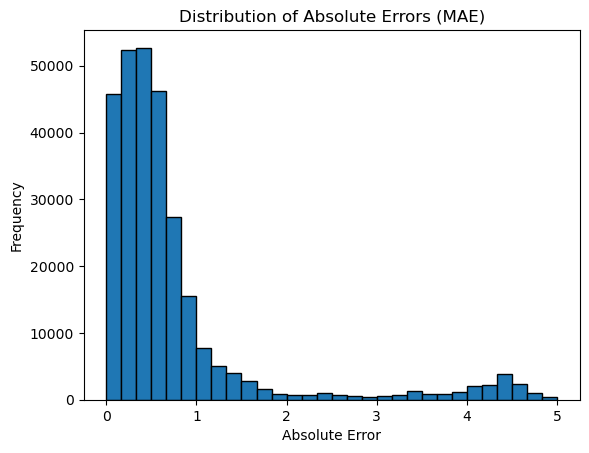

In [42]:
import numpy as np

absolute_errors = [abs(pred.est - pred.r_ui) for pred in predictions]  # For MAE
squared_errors = [(pred.est - pred.r_ui)**2 for pred in predictions]  # For RMSE

import matplotlib.pyplot as plt

plt.hist(absolute_errors, bins=30, edgecolor='black')
plt.title('Distribution of Absolute Errors (MAE)')
plt.xlabel('Absolute Error')
plt.ylabel('Frequency')
plt.show()


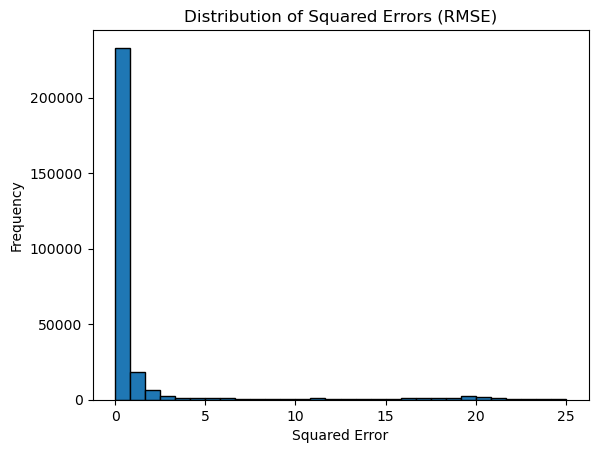

In [43]:
plt.hist(squared_errors, bins=30, edgecolor='black')
plt.title('Distribution of Squared Errors (RMSE)')
plt.xlabel('Squared Error')
plt.ylabel('Frequency')
plt.show()


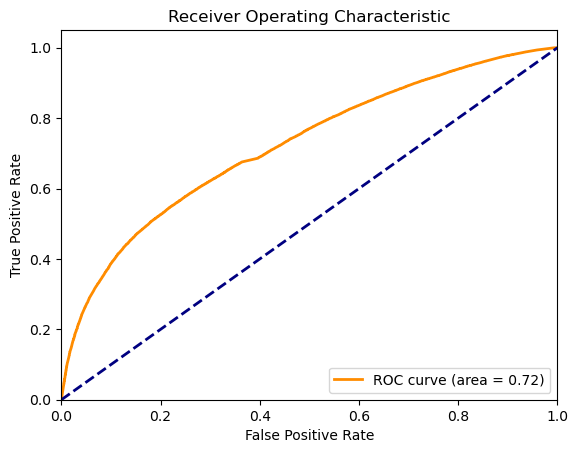

In [44]:
from sklearn.metrics import roc_curve, auc

threshold = 4
y_actual = [1 if pred.r_ui >= threshold else 0 for pred in predictions]
y_scores = [pred.est for pred in predictions]  # predicted ratings

fpr, tpr, thresholds = roc_curve(y_actual, y_scores)
roc_auc = auc(fpr, tpr)

import matplotlib.pyplot as plt

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


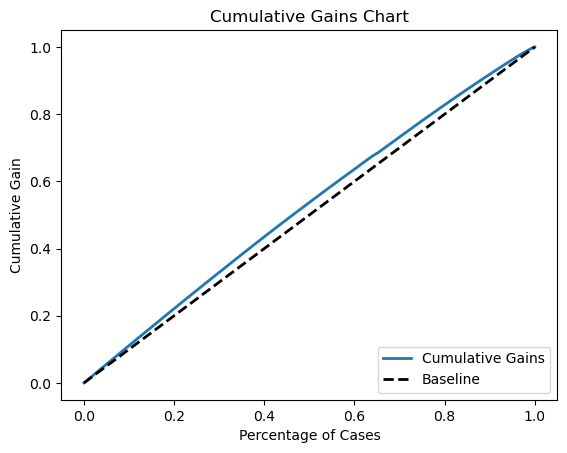

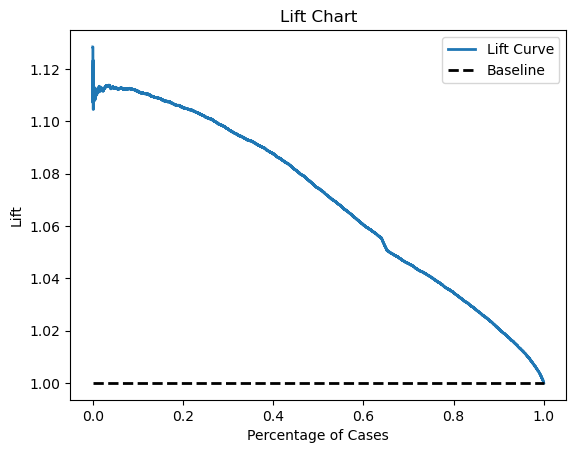

In [48]:
import numpy as np
import matplotlib.pyplot as plt

y_scores = np.array(y_scores)
y_actual = np.array(y_actual)

sorted_indices = np.argsort(y_scores)[::-1]
y_scores_sorted = y_scores[sorted_indices]
y_actual_sorted = y_actual[sorted_indices]

cumulative_gains = np.cumsum(y_actual_sorted) / sum(y_actual_sorted)
percentage_cases = np.arange(1, len(cumulative_gains) + 1) / len(y_scores_sorted)

plt.plot(percentage_cases, cumulative_gains, lw=2, label='Cumulative Gains')
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Baseline')
plt.xlabel('Percentage of Cases')
plt.ylabel('Cumulative Gain')
plt.title('Cumulative Gains Chart')
plt.legend(loc='lower right')
plt.show()

lift_values = cumulative_gains / percentage_cases

plt.plot(percentage_cases, lift_values, lw=2, label='Lift Curve')
plt.plot([0, 1], [1, 1], 'k--', lw=2, label='Baseline')
plt.xlabel('Percentage of Cases')
plt.ylabel('Lift')
plt.title('Lift Chart')
plt.legend(loc='upper right')
plt.show()
